## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [77]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [78]:
#uploud the data
df=pd.read_csv('ab_data.csv')
#see the first five rwos 
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [79]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [80]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [81]:
row_num = df.shape[0]
sum(df['converted'].values)/row_num

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [82]:
#rows when treatment user go incorrectly on old_page 
group_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print(len(group_1))

#rows when control user incorrectly go on new_page
group_2 = df.query("group == 'control' and landing_page == 'new_page'")
print(len(group_2))

#number of times the treatment and new page don't line up is sum of the previous answers
print("The number of times the new_page and treatment don't match {}".format(len(group_1) + len(group_2)))

1965
1928
The number of times the new_page and treatment don't match 3893


f. Do any of the rows have missing values?

In [83]:
#see if any missing values 
df.isnull().any(axis=1).sum() 

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [84]:
# first drop rows for mismatched treatment groups ...
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
# and drop rows for mismatched control groups ...
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [85]:
df.to_csv('ab_edited_version.csv', index=False)

In [86]:
# read the new (ab_edited_version) database and save it into df2
df2 = pd.read_csv('ab_edited_version.csv')

In [87]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [88]:
#sum number of unique users
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [89]:
#first check how many users are dublicated
sum(df2['user_id'].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [90]:
#query the df2 for dublicted in user column
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1876    773192
2862    773192
Name: user_id, dtype: int64

In [91]:
#print the ful user dublication info
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [92]:
#delete certin row based on timestamp that equal 2017-01-14 02:55:59.590927 
time_stamp= "2017-01-14 02:55:59.590927"
df2 = df2[df2.timestamp != time_stamp]


In [93]:
sum(df2['user_id'].duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [94]:
#Compute the mean to find the probability of an individual converting
Conv_mean = df2.converted.mean()
Conv_mean

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [95]:
#find the mean of converted for the control & treatement groups
group_conv = df2.groupby('group')['converted'].mean()
group_conv

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [96]:
#individual control group 
control_conv = df2[df2['group'] == 'control']['converted'].mean()
control_conv 

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [97]:
#individual treatment group 
tret_conv = df2[df2['group'] == 'treatment']['converted'].mean()
tret_conv 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [98]:
x=len(df2.query('landing_page =="new_page"'))

In [99]:
x/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

* we have conclude that there is no evidence that the new page (treatment) lead to more converted users ;
* In contrast the old page (control) slighitly bigger number of converted user than the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Suppousing that the old page is better to keep than implementing the new page  until the new page proves its efficiency.

So, Null hypothesis can be expressed like the mean of converted users od old page is equal or greater than the mean of converted users of the new page.

While the Alternative hypothesis will be the oppisite of null hypothesis (the mean of the converted users of the new page is greater than the mean od the converted users of the old page).


### Null Hypotheses:    $p_{old}$ is equal greater or equal to $p_{new}$

### Alternative Hypothesis:     $p_{old}$ is less than $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [100]:
Conv_mean = df2.converted.mean()
Conv_mean

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [101]:
Conv_mean = df2.converted.mean()
Conv_mean

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [102]:
individuals_new=df2.query('landing_page == "new_page"').shape[0]
individuals_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [103]:
individuals_old = df2.query('landing_page == "old_page"').shape[0]
individuals_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [104]:
new_PageConvert = np.random.choice([0, 1], size=individuals_new , p=[(1 - Conv_mean), Conv_mean])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [105]:
old_PageConvert = np.random.choice([0, 1], size=individuals_old , p=[(1 - Conv_mean), Conv_mean])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [109]:

new_PageConvert.mean() - old_PageConvert.mean()

-0.00039463603804580638

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [111]:

#create numpy array  
p_diffs = []

for i in range(10000):
    new_PageConvert = np.random.choice([0, 1], size=individuals_new, p=[(1 - Conv_mean), Conv_mean])
    old_PageConvert = np.random.choice([0, 1], size=individuals_old, p=[(1 - Conv_mean), Conv_mean])
    p_diffs.append(new_PageConvert.mean() - old_PageConvert.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   25.,   139.,   682.,  1703.,  2603.,  2569.,  1526.,   594.,
          139.,    20.]),
 array([ -4.20751753e-03,  -3.35543316e-03,  -2.50334878e-03,
         -1.65126441e-03,  -7.99180041e-04,   5.29043314e-05,
          9.04988703e-04,   1.75707308e-03,   2.60915745e-03,
          3.46124182e-03,   4.31332619e-03]),
 <a list of 10 Patch objects>)

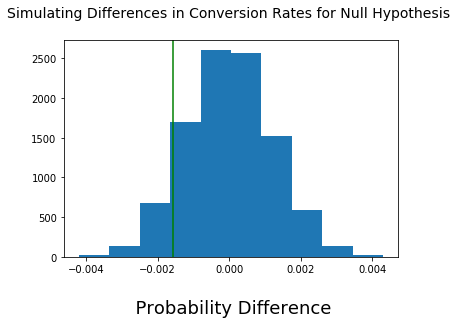

In [112]:

plt.axvline(tret_conv - control_conv, color='g');
plt.xlabel("\n  Probability Difference ", fontsize=18)
plt.title("Simulating Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [113]:
ab_data_diff = tret_conv - control_conv
# compute p-value
(p_diffs > ab_data_diff).mean()

0.90720000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?



**In statistical hypothesis testing is called (p-value) , the p-value or probability value is the mean of the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct 

### The lower the p-value, the more surprising the evidence is, the more ridiculous our null hypothesis looks.

If p > .10 → “not significant”

If p ≤ .10 → “marginally significant”

If p ≤ .05 → “significant”

If p ≤ .01 → “highly significant.”

So, p-value here is .9 which mean is high greater than the potintial significant results (.05 ). This is lead us to conclude that there is no efficient evidence that there is a difference between the two values(new page and old page).

**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [114]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [115]:
#z_score, p_value
sm.stats.proportions_ztest([convert_new, convert_old], [individuals_new, individuals_old], alternative='smaller')

(-1.3109241984234394, 0.094941687240975514)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

We know previously p-value in the privious step.
Z scores are measures of standard deviation. For example, if a tool returns a Z score of +2.5 it is interpreted as "+2.5 standard deviations away from the mean". 
the rate of new page conversion here is (-1.31) standard deviations from the conversion rate of old page. A negative z-score reveals the raw score is below the mean average.  z-score is equal to -1.31, it is 1.31 standard deviations below the mean. We cannot reject the null hypothesis that the mean of converted users in old page is equal or greater than the mean of converted users of the new page.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

linear regression that express the relationship between dependent varaible and one or more independent variables 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [116]:

df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [117]:
logModel = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logModel.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [118]:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:32:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

As seen in the table, the p-value for ab_page equal to 0.190. 

this value indicates that that new implemented page is not significant as 0.19 > 0.05. 
The values were not the same because in part (2), we randomly sampled the data (10000) times and the sample could be overlapped or equivalent that lead to different results such that differet p-values that differ than what we got in regression model.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Consider other factors in our regression model , give us more confidence about our hypothesis results and see if the results still the same or its reflect another indication that we may not see in the previous situation. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [128]:
countries = pd.read_csv('countries.csv')
#Merge the two dataframes using index as user_id
New_df = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner') 
New_df.head(6)

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0
909908,UK,2017-01-06 20:44:26.334764,treatment,new_page,0,1,1,0


In [129]:
# Create dummy variables
New_df[['US','UK','CA']]=pd.get_dummies(New_df['country'])
New_df.head(5)


,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [139]:
model = sm.Logit(New_df['converted'], New_df[['intercept', 'UK', 'US']])
results = model.fit()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [140]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 08 Dec 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:27:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [141]:
# Fit Linear Model 
model = sm.Logit(New_df['converted'], New_df[['intercept', 'UK', 'US', 'ab_page']])

results = model.fit()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 08 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:27:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

### Conclosion
The null hypothesis was the mean of converted users in old page is equal or greater than the mean of converted users of the new page.

While the Alternative hypothesis was (the mean of the converted users of the new page is greater than the mean od the converted users of the old page). The p-value is still large (.191). We conclude that we fail to reject the null hypothesis.
then , The company shouldn't implement the new page as there is no sufficient evidence for its effecicency in converting users rate than the old page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [143]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0